# `extra_H_rows.ipynb`
This file is for testing the theory of whether adding extra (formerly redundant) rows to the H matrix makes the LSE Hypothesis more true. If it works, it should be added to `WSN.py`.

If we add redundant rows to the H matrix, it should not change the answer, but in this case, the redundant rows only agree with existing rows if the peaks are correct. If they are incorrect, it will lead to more error. But as it stands, even with mTDOA with tree, we are still measuring time delays from a "root" anchor node by adding up the time delays. This would compound the error of some incorrect peaks while introducing little error for other incorrect peaks. Adding peaks together also makes the redundant edges far less effective. (See bottom of `peak_minimization2.ipynb`.) We would like to not have to add peaks together like this, but this means having multiple reference arrival times which come as outputs with cTDOA. We shall divide our nodes into clusters but then introduce redundant edges between clusters. Then the algorithm has to make sure the redundancy agrees with its output (of reference times) or else experience error. 

In [1]:
from WSN import *
import mutual_information as mtin
from scipy.signal import find_peaks
from color import *
from heapq import heapify, heappop, heappush
import itertools as it

In [2]:
mtin.default_fn_equ_params["dt"] = 0.01
mtin.default_fn_equ_params["T"] = 20_000
mtin.default_fn_equ_params['stim'] = [[[250, 350], [45, 65], [45, 65]]]
start_frame = int(40 / mtin.default_fn_equ_params["dt"])
mtin.default_fn_equ = FHN(**mtin.default_fn_equ_params)

In [3]:
if mtin.default_fn_sol is None:
    mtin.default_fn_sol = np.load("default_fn_sol_dt_0.01.npy")

In [4]:
# mtin.solve_default_fn_equ()

In [5]:
# np.save("default_fn_sol_dt_0.01.npy", mtin.default_fn_sol)

In [30]:
def find_clusters(self: WSN, min_cluster_size=None, redundant_nodes_per_cluster=0):
    if min_cluster_size is None:
        min_cluster_size = self.cluster_size

    unreached_nodes = list(range(len(self.nodes)))
    clusters = []
    while len(unreached_nodes) != 0:
        # Create a new cluster
        root_ind = np.random.randint(0, len(unreached_nodes))
        root = unreached_nodes.pop(root_ind)
        nodes_heap = [[dist2(self.nodes[x], self.nodes[root]), x] for x in unreached_nodes]
        cluster = [root]
        redundant_nodes = []
        for i in range(min_cluster_size - 1 + redundant_nodes_per_cluster):
            if len(nodes_heap) == 0:
                break
            heapify(nodes_heap)
            d, next_node = heappop(nodes_heap)
            cluster.append(next_node)
            for x in nodes_heap:
                x[0] = min(x[0], dist2(self.nodes[x[1]], self.nodes[next_node]))
            if i >= min_cluster_size - 1:
                redundant_nodes.append(next_node)
        clusters.append(cluster)
        unreached_nodes = [x[1] for x in nodes_heap] + redundant_nodes
    if len(clusters[-1]) < min_cluster_size:
        clusters[-2] += clusters[-1]
        clusters.pop()
        clusters[-1] = list(set(clusters[-1]))
    return clusters
    

In [ ]:
# Generate signals and find all peaks
def get_all_fn_peaks_by_cluster(self: WSN, r0=None, clusters=None, verbose=None):
    if r0 is None:
        r0 = np.array([55, 55])
    if verbose is None:
        verbose = self.verbose
    if clusters is None:
        clusters = [list(range(len(self.nodes)))]
    results = self.transmit_continuous(signal_type="fn", start_frame=start_frame)
    assert np.all(np.array([result[0] for result in results]) == self.nodes)

    all_peaks = []   # [(rn, rm, p, array([p1, p2, p3])), ...]
    pair_to_ind = {} # {(n, m): i}
    cluster_MSTs = []

    for cluster in clusters:
        cluster_nodes = self.nodes[cluster]
        cluster_MST = self.find_MST(cluster_nodes)
        cluster_MSTs.append(cluster_MST)
        for _, i, j in cluster_MST:
            i, j = cluster[i], cluster[j]
            ri, sigi = results[i]
            rj, sigj = results[j]
            dt = mtin.default_fn_equ_params["dt"]
            max_delay = dist(ri, rj) / self.c
            max_tau = int((max_delay + 4) / dt)
            shifts = np.arange(-max_tau, max_tau, 1)
            mis = mtin.mi_shift(np.transpose([sigi, sigj]), shifts)

            max_peak = max(mis)
            inclusion_factor = 0.5
            peaks, _ = find_peaks(mis, height=max_peak * inclusion_factor)
            if verbose and np.random.uniform(0, 1) < 0.1:
                plt.plot(shifts, mis)
                plt.show()
            if len(peaks) == 0:
                plt.plot(shifts * mtin.default_fn_equ_params["dt"], mis)
                plt.show()
                p = (dist(ri, r0) - dist(rj, r0)) / c
                raise ValueError(
                    f"No peaks found between nodes {i} and {j} "
                    f"at positions {ri} and {rj}.\n"
                    f"The peak should be at time {p}."
                )
            peaks = shifts[peaks] * dt

            p = (dist(ri, r0) - dist(rj, r0)) / c
            pair_to_ind[(i, j)] = len(all_peaks)
            all_peaks.append((ri, rj, p, peaks))
    return all_peaks, pair_to_ind, cluster_MSTs


In [25]:
# Find outputs for every peaks in all_peaks
def get_peaks_outputs_by_cluster(self: WSN, all_peaks, pair_to_ind, clusters, cluster_MSTs, r0=None):
    if r0 is None:
        r0 = np.array([55, 55])
    num_clusters = len(clusters)
    
    cluster_trees = [] # [{n: [...]}, ...]
    for cluster, cluster_MST in zip(clusters, cluster_MSTs):
        tree_dict = {n: [] for n in cluster}
        for _, i, j in cluster_MST:
            i, j = cluster[i], cluster[j]
            tree_dict[i].append(j)
            tree_dict[j].append(i)
        cluster_trees.append(tree_dict)

    

    output = []

    pinds = [0] * len(all_peaks)
    d = 0
    while True:
        # Get H and b
        cluster_delays = []
        for cluster, cluster_tree in zip(clusters, cluster_trees):
            r1 = cluster[0]
            delays = {r1: 0}

            def get_child_delays(root):
                children = cluster_tree[root]
                for child in children:
                    if child in delays:
                        continue

                    if (root, child) in pair_to_ind:
                        i = pair_to_ind[(root, child)]
                        rn, rm, p, peaks = all_peaks[i]
                        p = -p
                        peaks = -peaks
                    else:
                        i = pair_to_ind[(child, root)]
                        rn, rm, p, peaks = all_peaks[i]
                    peak = peaks[pinds[i]] if d != 0 else p
                    delays[child] = delays[root] + peak
                    get_child_delays(child)
            get_child_delays(r1)
            cluster_delays.append(delays)

        Hb = [
            self.get_cTDOA_H_and_b_submatrix(
                [(self.nodes[n], cluster_delays[c][n]) for i, n in enumerate(cluster) if i != 0],
                num_clusters,
                c
            )
            for c, cluster in enumerate(clusters)
        ]
        # Hb = list(np.array(Hb, dtype='object').T)
        H = np.array([
            Hn
            for Hc, bc in Hb
            for Hn in Hc
        ])
        b = np.array([
            bn
            for Hc, bc in Hb
            for bn in bc
        ])

        # Calculate position
        Hpinv = np.linalg.pinv(H)
        x = Hpinv @ b
        est_pos = x[:2]
        c2 = x[2]

        # Calculate error
        least_squared = (np.eye(len(b)) - H @ Hpinv) @ b
        lse = np.dot(least_squared, least_squared)

        distance_err = dist(est_pos, r0)
        speed_squared_err = np.abs(c2 - self.c ** 2)

        # Calculate redundancy error
        redundancy_err = 0
        # find nodes that appear in multiple clusters
        for n in range(len(self.nodes)):
            matching_clusters = []
            for c, cluster_delay in enumerate(cluster_delays):
                if n in cluster_delay:
                    matching_clusters.append(c)
            if len(matching_clusters) <= 1:
                continue
            for i in range(len(matching_clusters) - 1):
                for j in range(1, len(matching_clusters)):
                    ci, cj = matching_clusters[i], matching_clusters[j]
                    redundancy_err += c2 * \
                        np.power(
                            (-x[ci + 3] / c2 + cluster_delays[ci][n]) - 
                            (-x[cj + 3] / c2 + cluster_delays[cj][n])
                            , 2
                        )

        # Add position and error to output matrix
        output.append((
            lse,
            distance_err,
            speed_squared_err,
            tuple(pinds) if d != 0 else [-1] * len(pinds),
            [all_peaks[i][3][pind] for i, pind in enumerate(pinds)] if d != 0 else [p for _, _, p, _ in all_peaks],
            x,
            redundancy_err
        ))


        # Increment peak indices
        # If finished, break
        if d != 0:
            for b in range(len(pinds)):
                pinds[b] += 1
                if pinds[b] >= len(all_peaks[b][3]):
                    pinds[b] = 0
                else:
                    break
            else:
                break
        d += 1
    real_peaks = output[0]
    output.pop(0)
    return real_peaks, output

def find_most_realistic_peaks(self, output, real_peaks):
    return min(output, key=lambda x: np.sum(np.abs(np.array(x[4]) - np.array(real_peaks[4]))))

In [31]:
[setattr(WSN, attr, globals()[attr]) for attr in (
    "find_clusters",
    "get_all_fn_peaks_by_cluster",
    "get_peaks_outputs_by_cluster",
    "find_most_realistic_peaks"
)]

[None, None, None, None]

In [10]:
LSE, DISTANCE_ERR, SPEED_SQUARED_ERR, PINDS, PEAKS, X, REDUNDANCY_ERR = range(7)

In [11]:
def print_peaks_with_labels(peaks):
    labels = [
        "LSE",
        "DISTANCE_ERROR",
        "SPEED_SQUARED_ERR",
        "PINDS",
        "PEAKS",
        "X",
        "REDUNDANCY_ERR"
    ]
    [print("    " + label + ": " + str(x)) for label, x in zip(labels, peaks)]
    print()


In [27]:
# Create the WSN
N = 16
c = 1.6424885622140555
r0 = np.array([55, 55])
wsn = WSN(100, N, std=0, D=142, c=c, verbose=True)
wsn.reset_nodes()
# wsn.nodes[:, 1] /= 2
# wsn.nodes = np.random.uniform(0, 50, size=[N, 2])
wsn.reset_anchors(range(N))

16


[[12, 13, 1, 9], [9, 5, 8, 11], [15, 2, 14, 7], [6, 0, 3, 7], [10, 11, 4, 7]]


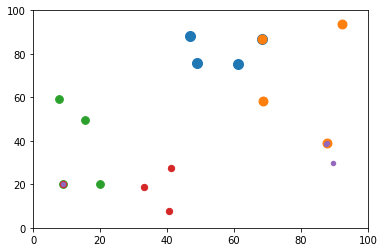

In [39]:
# Visualize clusters
clusters = wsn.find_clusters(redundant_nodes_per_cluster=1)
print(clusters)
for i, cluster in enumerate(clusters):
    nodes = wsn.nodes[cluster]
    plt.scatter(*nodes.T, s=100 *(len(clusters)-i) / len(clusters))
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.show()

In [40]:
# clusters = wsn.find_clusters()
all_peaks, pair_to_ind, cluster_MSTs = wsn.get_all_fn_peaks_by_cluster(clusters=clusters)
real_peaks, output = wsn.get_peaks_outputs_by_cluster(all_peaks, pair_to_ind, clusters, cluster_MSTs)


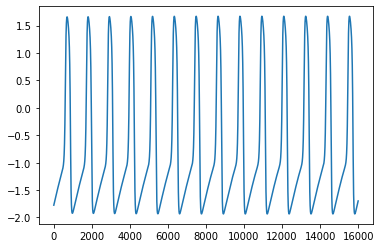

In [15]:
plt.plot(mtin.default_fn_sol[start_frame:, 0, 10, 10])
plt.show()

In [16]:
print("Real peaks")
print_peaks_with_labels(real_peaks)
most_realistic_peaks = wsn.find_most_realistic_peaks(output, real_peaks)
print("Most realistic peaks")
print_peaks_with_labels(most_realistic_peaks)
output.sort()
print("LSE Peaks")
print_peaks_with_labels(output[0])


Real peaks
    LSE: 2.6577478679010003e-22
    DISTANCE_ERROR: 1.4210854715202004e-14
    SPEED_SQUARED_ERR: 9.769962616701378e-15
    PINDS: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    PEAKS: [8.495647911935201, 4.867189718641105, -6.315410564452491, -6.543689446953835, -0.5507186788776497, -5.972915060263635, 7.815588809112198, -2.3759199323903406, -6.754497729815958, 14.116995447905577, 6.700380758551707, 1.4097296329540154, -25.279198477718136, 4.84874970158422, -5.300042004369463]
    X: [ 55.          55.           2.69776868 -59.81591773 -71.18486707
 -66.21375955 -91.88935503 -22.64808449]
    REDUNDANCY_ERR: 244.48376033425893

Most realistic peaks
    LSE: 46333.8786858088
    DISTANCE_ERROR: 0.9255215868165899
    SPEED_SQUARED_ERR: 0.3669765594644483
    PINDS: (2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 1, 0)
    PEAKS: [8.34, 5.39, -4.41, -5.9, -0.45, -5.73, 6.54, -2.13, -5.16, 12.3, 7.28, 0.32, -26.6, 8.22, -5.54]
    X: [ 54.54715187  54.19283287   3.06

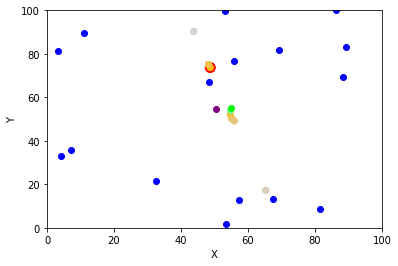

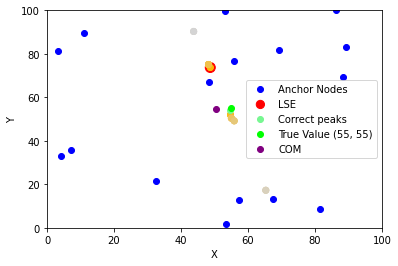

In [17]:
est_poss = [out[X][:2] for out in output[:30]]
est_poss = np.array(est_poss)
mean = np.mean(wsn.nodes, axis=0)

for a in range(2):
    plt.scatter(*wsn.nodes.T, c="blue", label="Anchor Nodes")
    plt.scatter(*est_poss.T, c=["#ff0000"] + [interpolate_color("#ffb700", "#d4d4d4", alpha).get_hex() for alpha in np.linspace(0, 1, len(est_poss) - 1)], label="LSE",
                s=[100] + [36] * (len(est_poss) - 1))
    plt.scatter(*most_realistic_peaks[X][:2], c=["#77f791"], label="Correct peaks")
    plt.scatter(55, 55, c="#00ff00", label="True Value (55, 55)")
    plt.scatter(*mean, c="purple", label="COM")
    plt.xlim((0, 100))
    plt.ylim((0, 100))
    plt.xlabel("X")
    plt.ylabel("Y")
    if a:
        plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


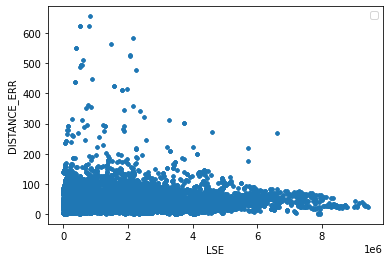

86400 data points


In [18]:
label, ind = "LSE", LSE
output.sort(key=lambda x: x[ind])
errs = [out[ind] for out in output]
plt.scatter(errs, [out[DISTANCE_ERR] for out in output], s=10)
i = output.index(most_realistic_peaks)
# plt.plot((i, i), (min(errs), max(errs)), c="gray", label=f"Correct peaks: ({i}, {output[i][ind]:.2f})")
# plt.ylim((0, wsn.c))
# plt.ylabel(label)
# plt.xlabel(f"Peak outputs sorted by {label}")
plt.xlabel(label)
plt.ylabel("DISTANCE_ERR")
plt.legend()
plt.show()
print(f"{len(output)} data points")

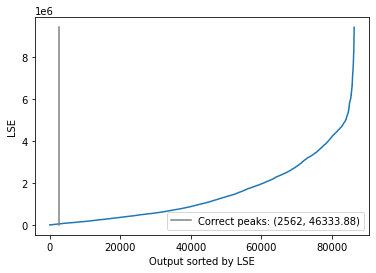

In [20]:
label, ind = "LSE", LSE
output.sort(key=lambda x: x[ind])
errs = [out[ind] for out in output]
plt.plot(errs)
plt.plot((i, i), (min(errs), max(errs)), c="gray", label=f"Correct peaks: ({i}, {output[i][ind]:.2f})")
plt.xlabel(f"Output sorted by {label}")
plt.ylabel(label)
plt.legend()
plt.show()


Get information about the location of the correct peaks.
* Do the correct peaks tend toward a specific position on the list sorted by LSE? Or do they tend toward a location scaled by the length of the list (e.g. 10% percentile)?
* What is the average LSE of the most realistic peaks? Is it sensitive to the size of the list?

In [21]:
MR_INDEX, MR_LSE, BEST_LSE, OUTPUT_LENGTH = range(4)

  1%|          | 1/100 [01:06<1:49:31, 66.37s/it]

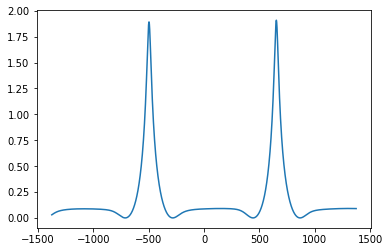

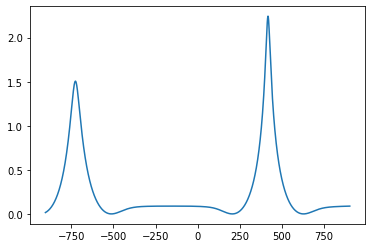

  2%|▏         | 2/100 [03:16<2:49:52, 104.00s/it]

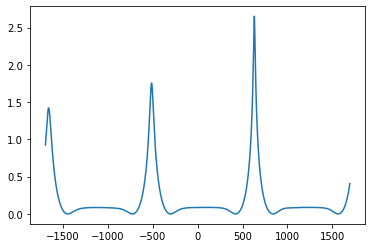

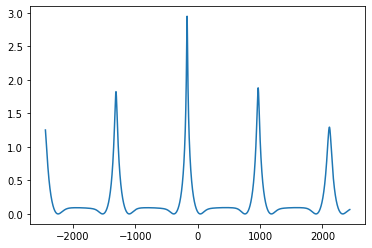

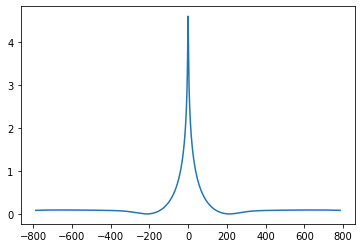

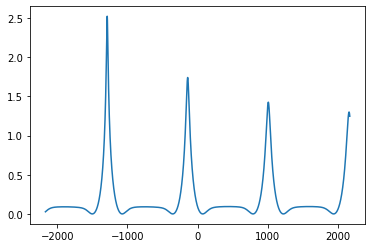

  5%|▌         | 5/100 [1:09:13<37:02:30, 1403.69s/it]

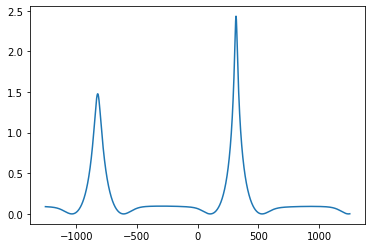

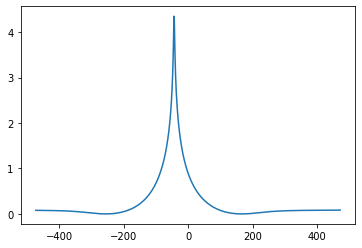

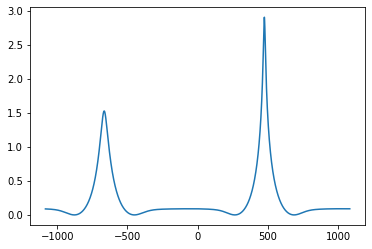

  6%|▌         | 6/100 [1:11:31<25:24:44, 973.24s/it] 

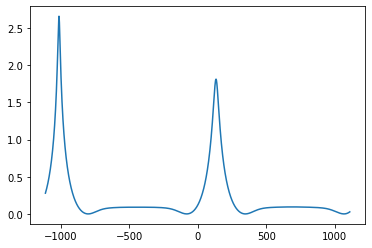

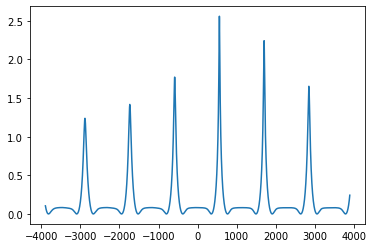

  7%|▋         | 7/100 [1:13:23<17:51:54, 691.56s/it]

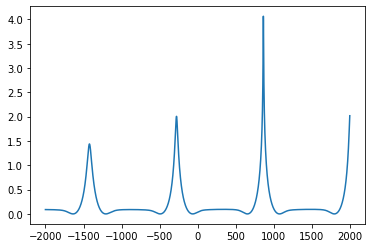

  9%|▉         | 9/100 [1:18:06<10:19:32, 408.48s/it]

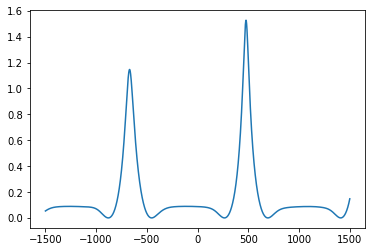

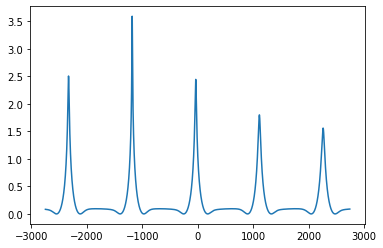

 10%|█         | 10/100 [1:22:21<9:01:45, 361.17s/it]

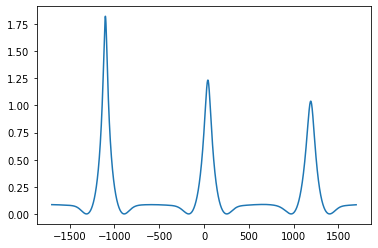

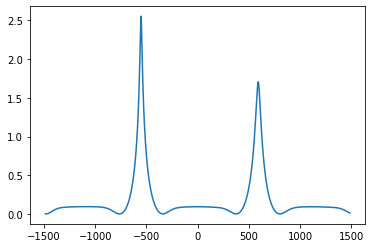

 12%|█▏        | 12/100 [1:27:13<6:17:53, 257.66s/it]

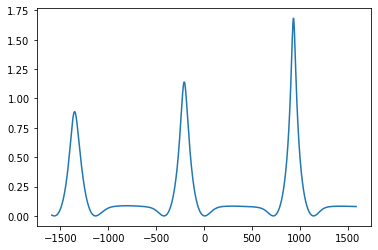

 13%|█▎        | 13/100 [1:28:05<4:43:33, 195.56s/it]

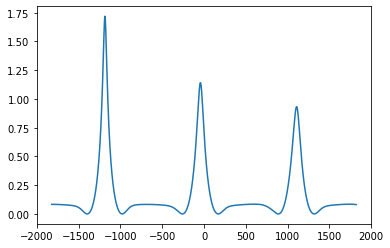

 14%|█▍        | 14/100 [1:53:56<14:27:01, 604.91s/it]

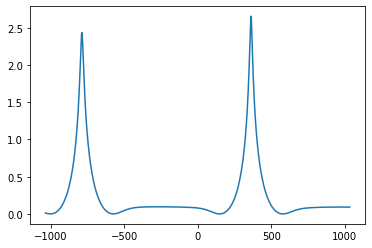

 15%|█▌        | 15/100 [1:56:42<11:09:19, 472.47s/it]

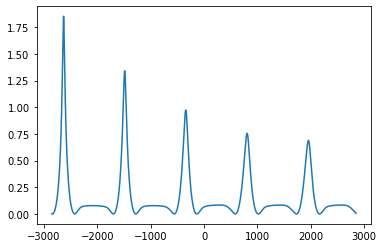

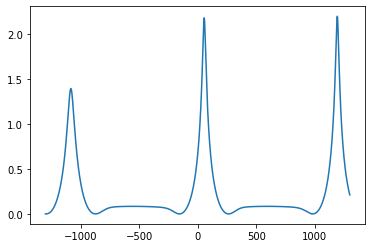

 16%|█▌        | 16/100 [2:01:18<9:38:36, 413.29s/it] 

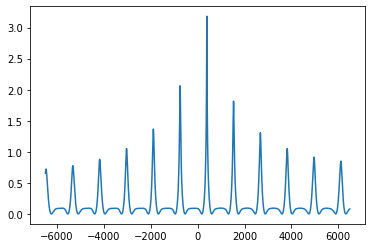

 18%|█▊        | 18/100 [2:20:50<12:01:11, 527.71s/it]

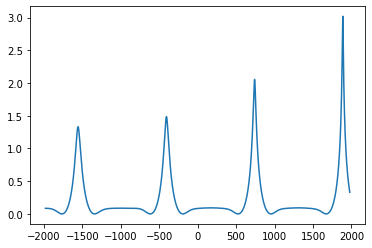

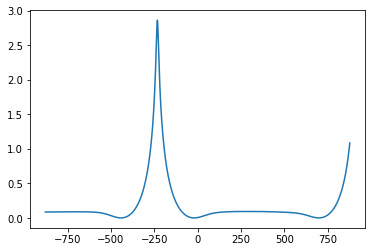

 20%|██        | 20/100 [2:25:45<7:39:14, 344.44s/it] 

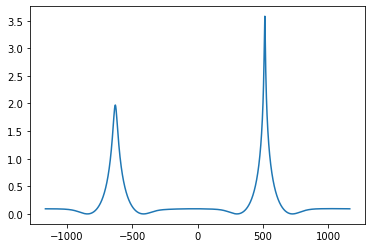

 21%|██        | 21/100 [2:28:37<6:25:17, 292.63s/it]

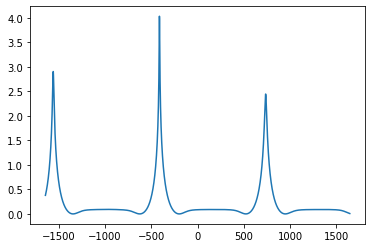

 22%|██▏       | 22/100 [2:54:27<14:31:06, 670.09s/it]

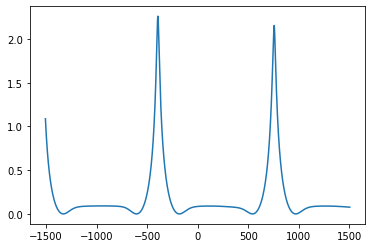

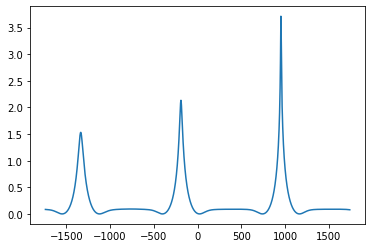

 23%|██▎       | 23/100 [2:55:28<10:25:17, 487.24s/it]

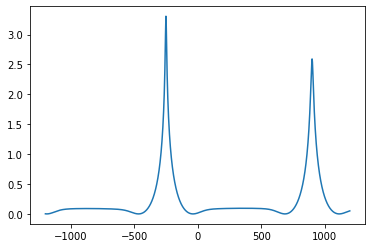

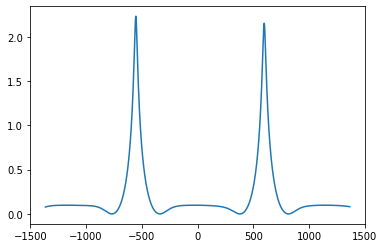

 24%|██▍       | 24/100 [2:56:45<7:41:08, 364.06s/it] 

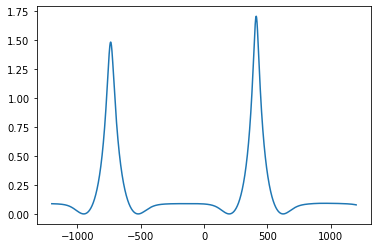

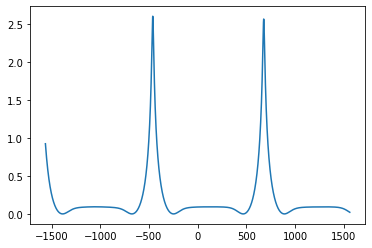

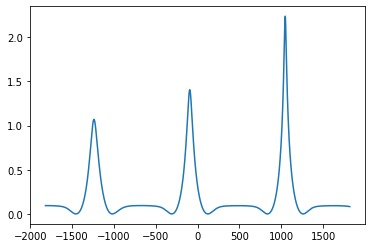

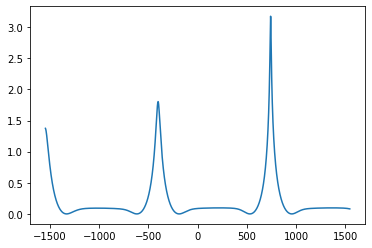

 25%|██▌       | 25/100 [3:05:44<8:40:52, 416.70s/it]

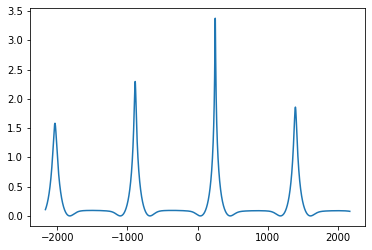

 27%|██▋       | 27/100 [3:27:37<11:38:43, 574.30s/it]

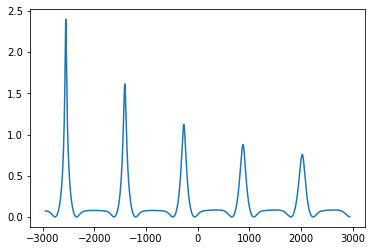

 28%|██▊       | 28/100 [3:29:44<8:48:23, 440.33s/it] 

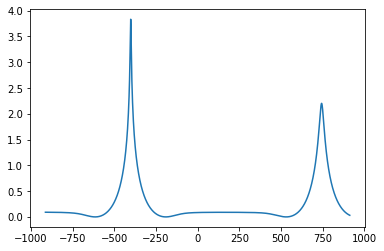

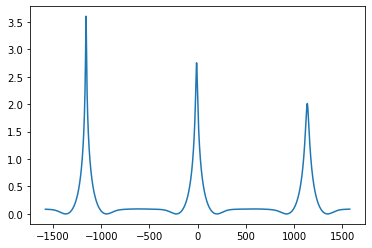

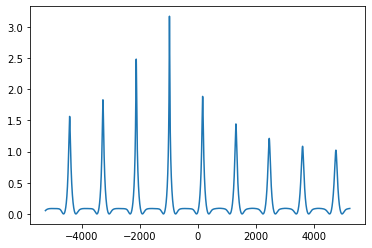

 29%|██▉       | 29/100 [3:30:23<6:18:39, 320.00s/it]

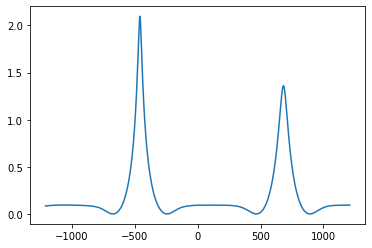

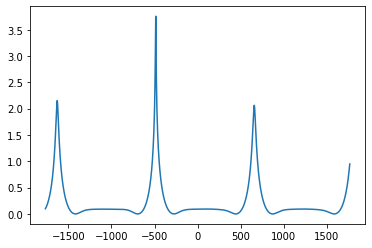

 30%|███       | 30/100 [3:48:33<10:42:33, 550.76s/it]

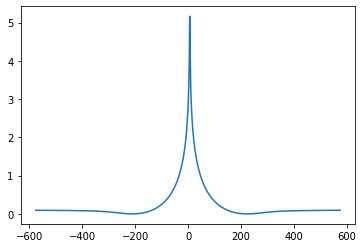

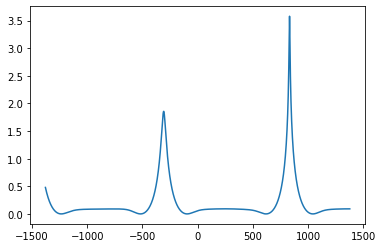

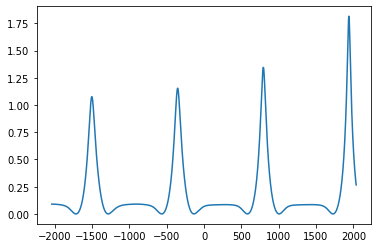

 31%|███       | 31/100 [3:50:14<7:58:17, 415.91s/it] 

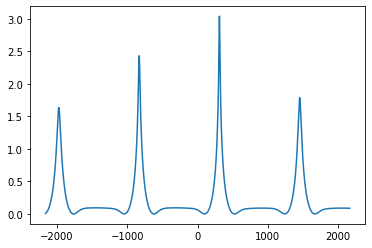

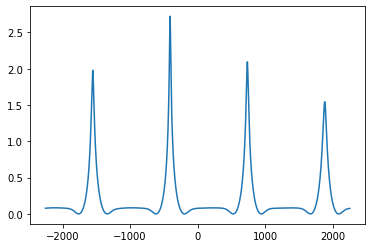

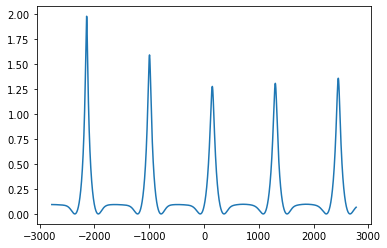

 32%|███▏      | 32/100 [12:55:07<190:45:41, 10099.15s/it]

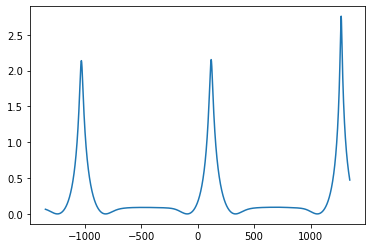

 33%|███▎      | 33/100 [12:55:37<131:44:21, 7078.53s/it] 

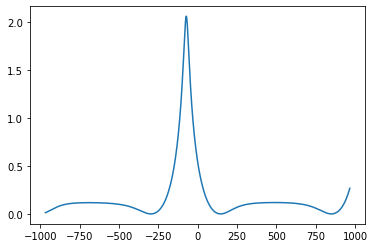

 34%|███▍      | 34/100 [12:58:57<91:56:14, 5014.76s/it] 

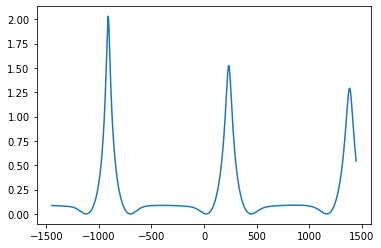

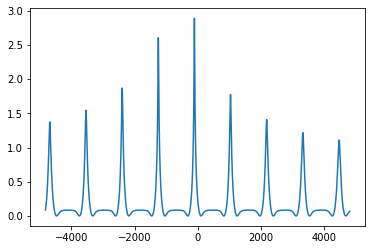

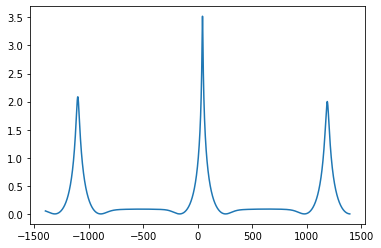

 35%|███▌      | 35/100 [13:17:45<69:29:26, 3848.71s/it]

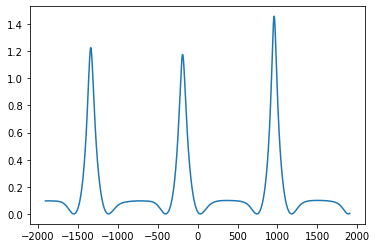

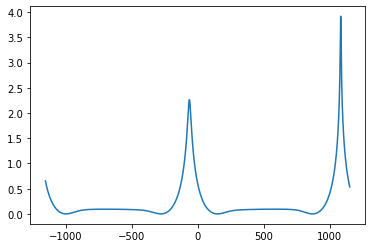

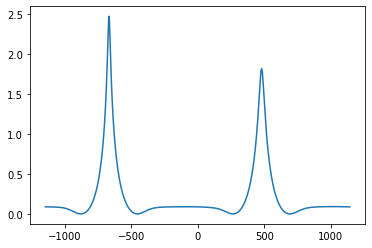

 36%|███▌      | 36/100 [13:40:41<55:14:12, 3107.07s/it]

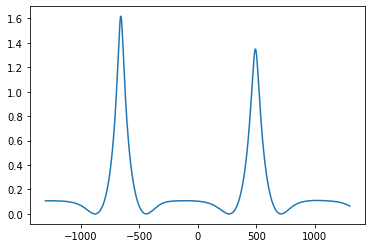

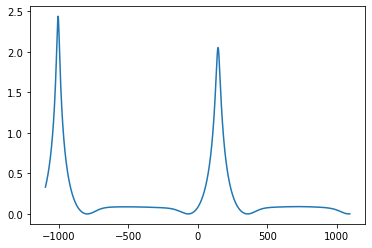

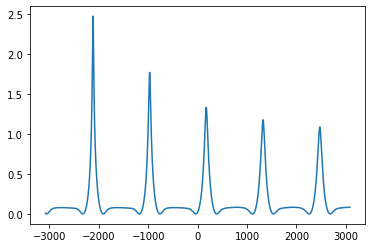

 37%|███▋      | 37/100 [13:43:09<38:50:19, 2219.36s/it]

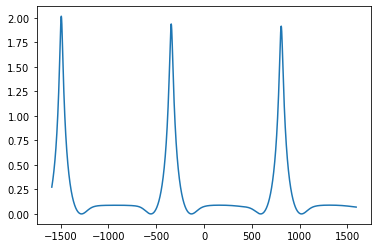

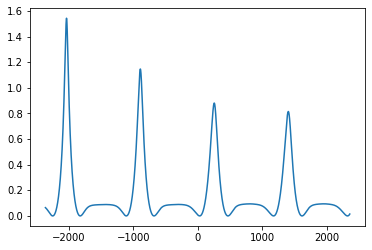

 38%|███▊      | 38/100 [13:45:14<27:24:01, 1591.00s/it]

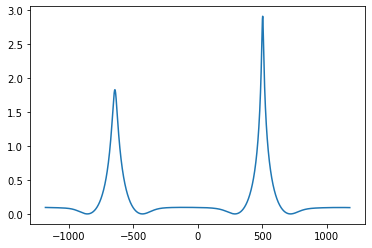

 39%|███▉      | 39/100 [13:47:16<19:29:20, 1150.18s/it]

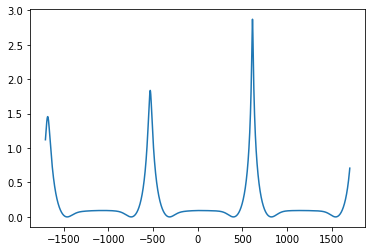

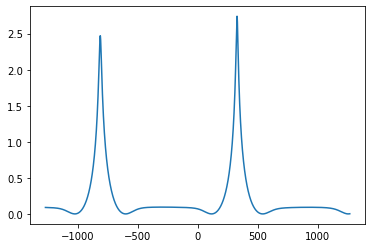

 41%|████      | 41/100 [13:50:40<10:05:36, 615.88s/it] 

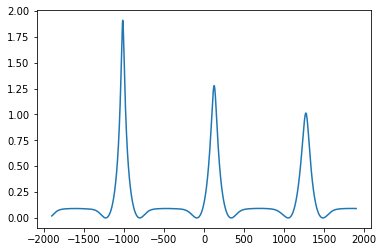

 42%|████▏     | 42/100 [14:03:58<10:48:08, 670.49s/it]

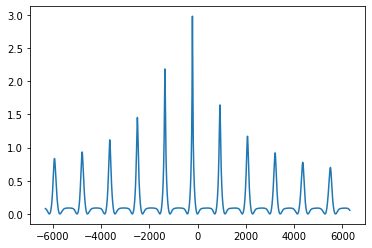

 43%|████▎     | 43/100 [14:07:57<8:33:57, 541.02s/it] 

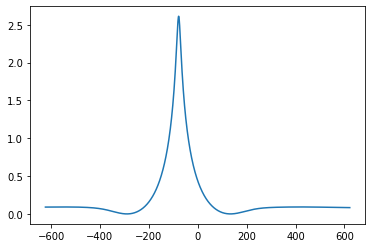

 44%|████▍     | 44/100 [14:08:33<6:03:25, 389.38s/it]

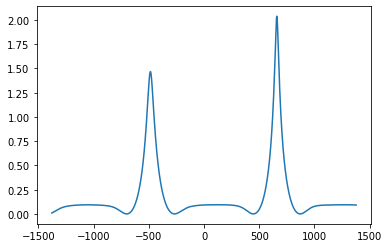

 45%|████▌     | 45/100 [14:13:48<5:36:38, 367.25s/it]

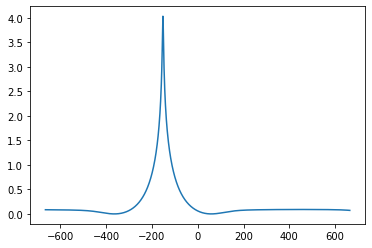

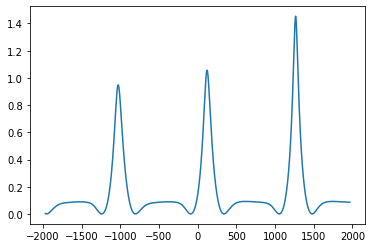

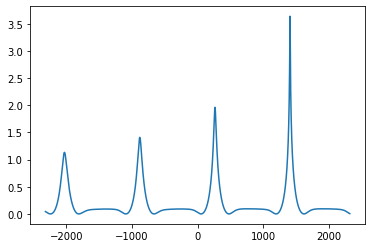

 46%|████▌     | 46/100 [14:14:57<4:10:00, 277.79s/it]

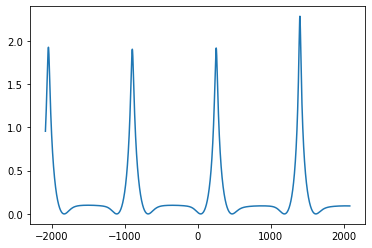

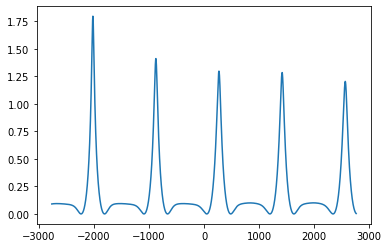

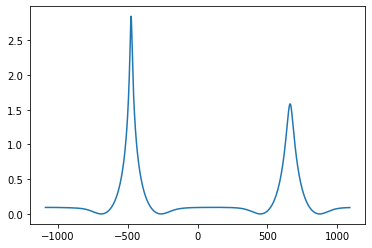

 47%|████▋     | 47/100 [14:20:40<4:22:29, 297.16s/it]

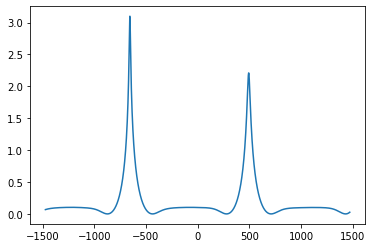

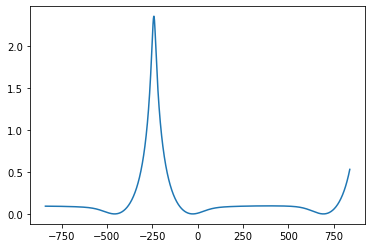

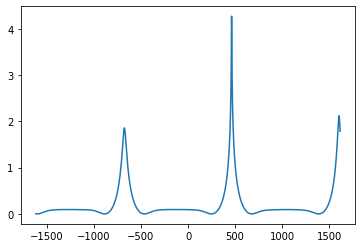

 48%|████▊     | 48/100 [14:20:56<3:04:33, 212.94s/it]

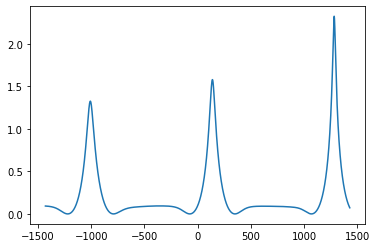

 51%|█████     | 51/100 [14:28:38<2:23:30, 175.72s/it]

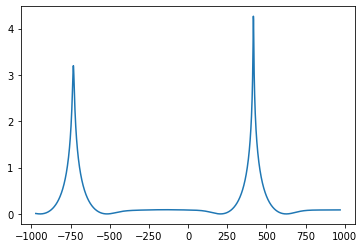

 52%|█████▏    | 52/100 [14:31:41<2:22:22, 177.96s/it]

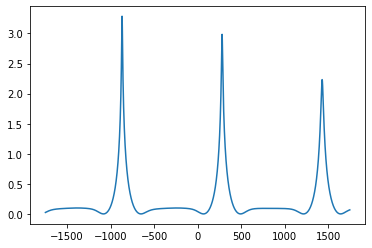

 53%|█████▎    | 53/100 [14:32:19<1:46:36, 136.09s/it]

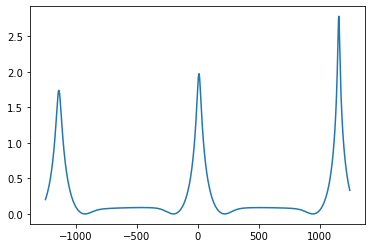

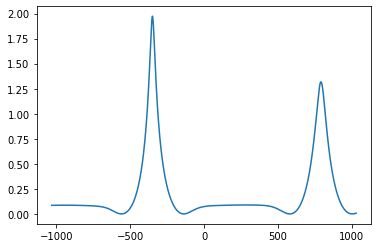

 54%|█████▍    | 54/100 [14:38:26<2:37:25, 205.34s/it]

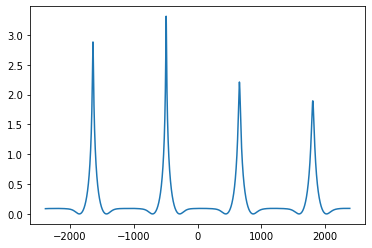

 55%|█████▌    | 55/100 [14:42:36<2:44:00, 218.67s/it]

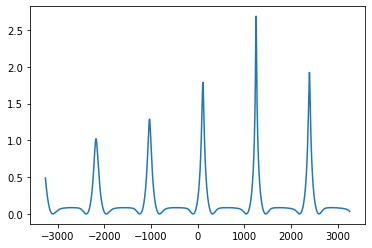

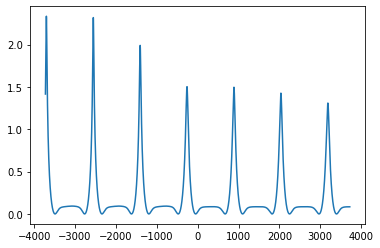

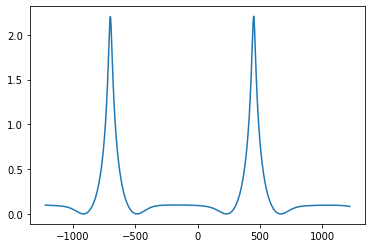

 57%|█████▋    | 57/100 [14:59:55<4:58:09, 416.04s/it]

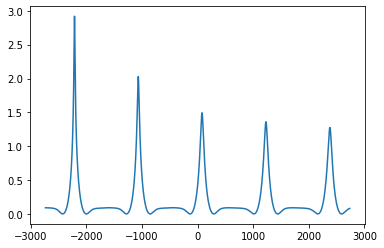

 58%|█████▊    | 58/100 [15:01:53<3:48:34, 326.54s/it]

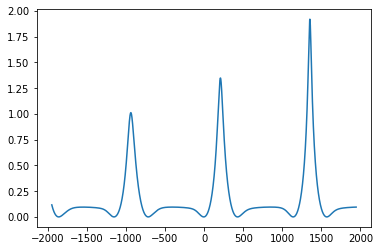

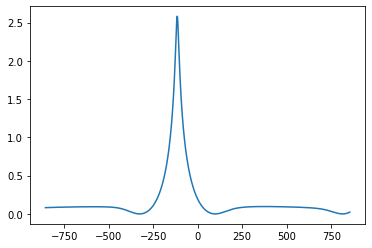

 59%|█████▉    | 59/100 [15:06:20<3:30:52, 308.60s/it]

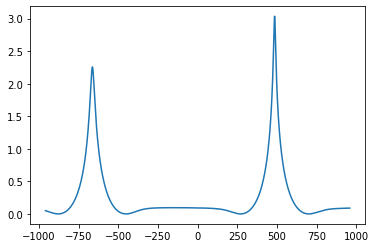

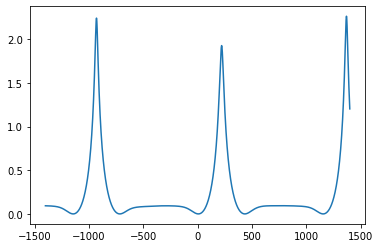

 60%|██████    | 60/100 [15:16:50<4:30:11, 405.28s/it]

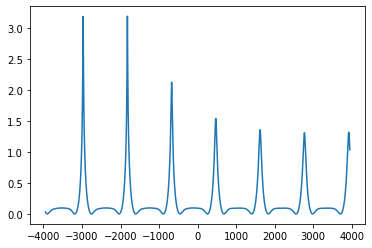

 61%|██████    | 61/100 [15:21:18<3:56:38, 364.05s/it]

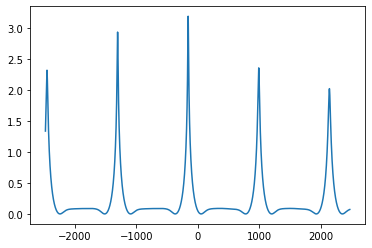

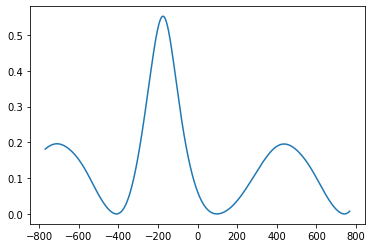

 62%|██████▏   | 62/100 [15:22:48<2:58:22, 281.65s/it]

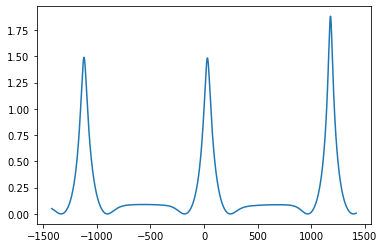

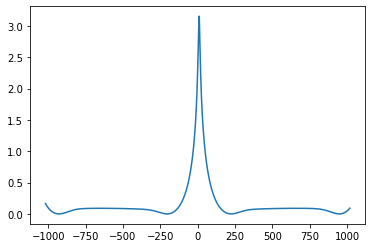

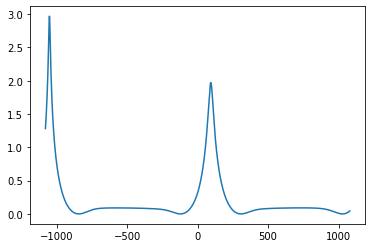

 63%|██████▎   | 63/100 [15:25:31<2:31:49, 246.21s/it]

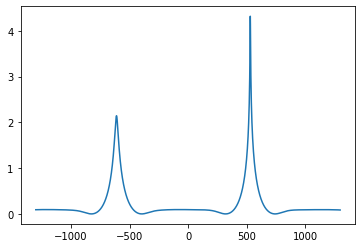

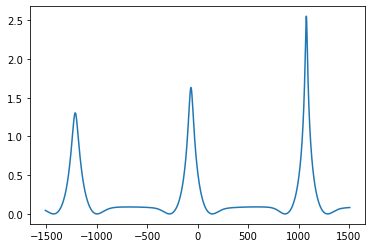

 64%|██████▍   | 64/100 [15:26:55<1:58:30, 197.52s/it]

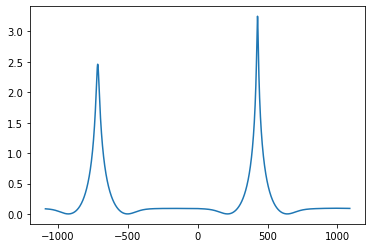

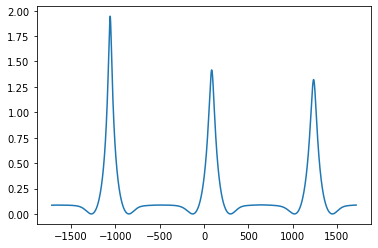

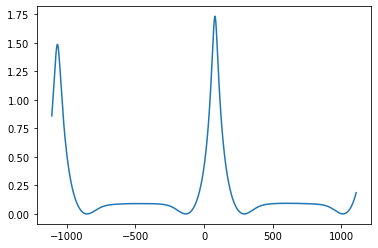

 65%|██████▌   | 65/100 [15:28:12<1:34:04, 161.29s/it]

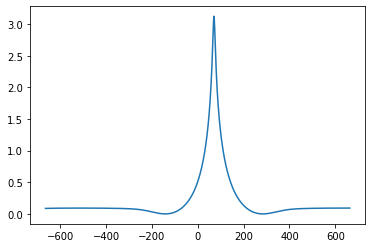

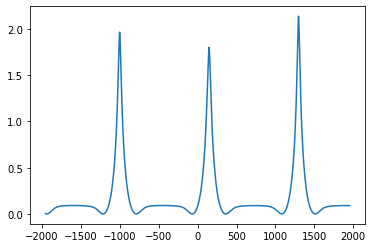

 69%|██████▉   | 69/100 [15:36:09<1:01:13, 118.51s/it]

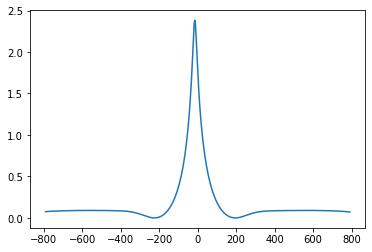

 71%|███████   | 71/100 [15:38:29<45:52, 94.90s/it]   

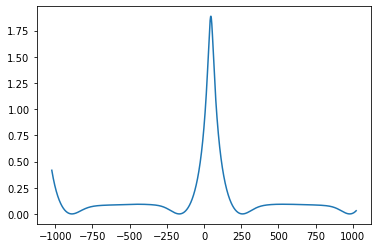

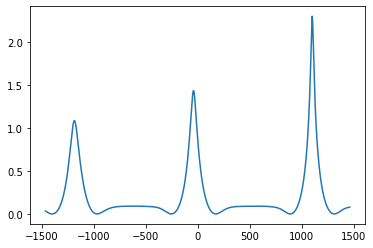

 72%|███████▏  | 72/100 [15:40:37<48:56, 104.87s/it]

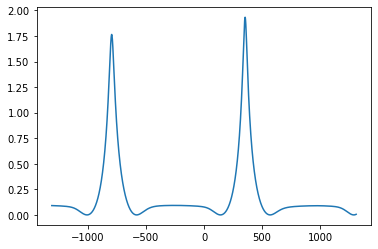

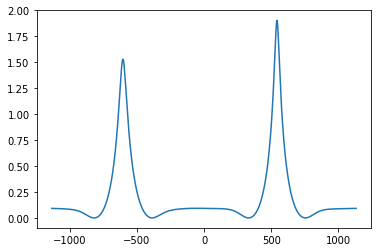

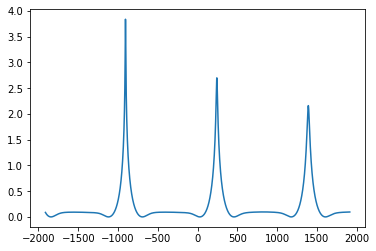

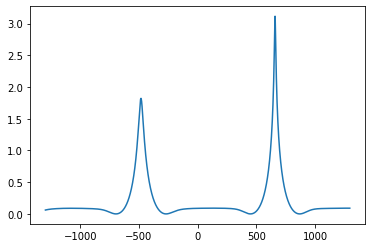

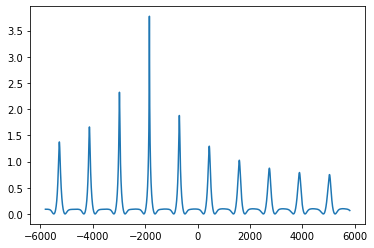

 73%|███████▎  | 73/100 [15:41:43<41:55, 93.16s/it] 

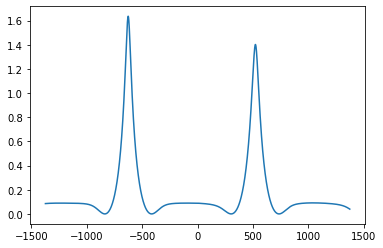

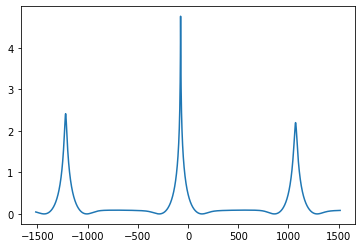

 74%|███████▍  | 74/100 [15:42:14<32:15, 74.44s/it]

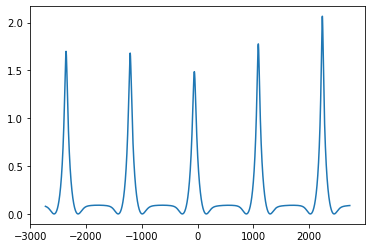

 75%|███████▌  | 75/100 [15:42:41<25:08, 60.35s/it]

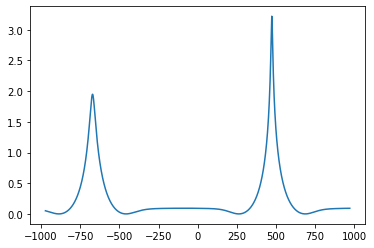

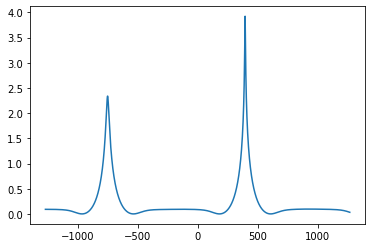

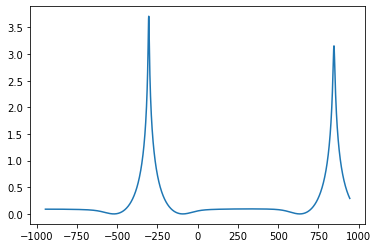

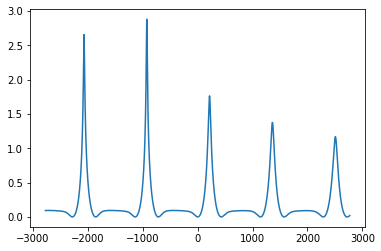

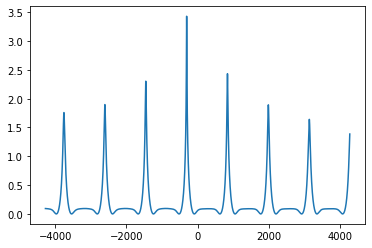

 76%|███████▌  | 76/100 [16:07:55<3:18:33, 496.38s/it]

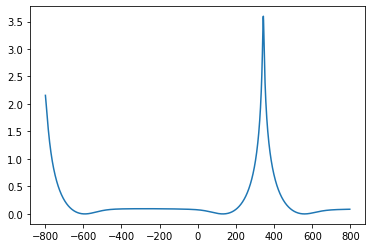

 77%|███████▋  | 77/100 [16:09:38<2:25:04, 378.45s/it]

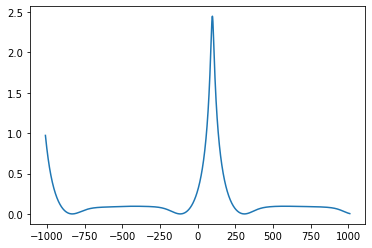

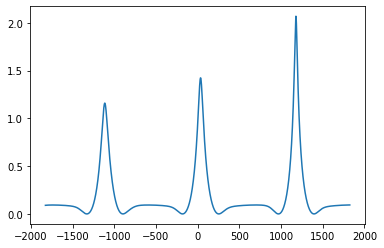

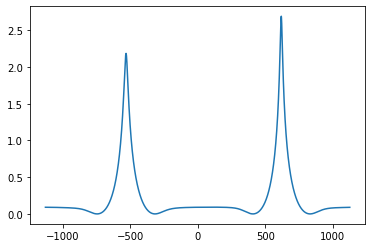

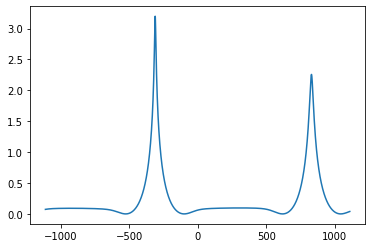

 78%|███████▊  | 78/100 [16:11:18<1:48:03, 294.68s/it]

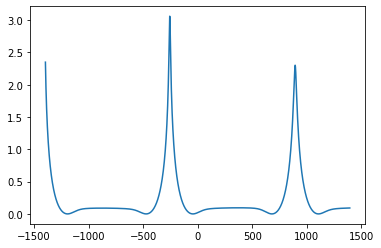

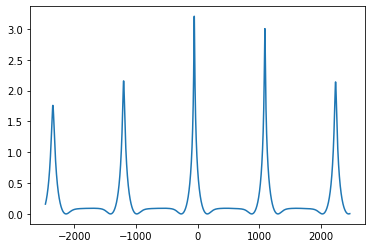

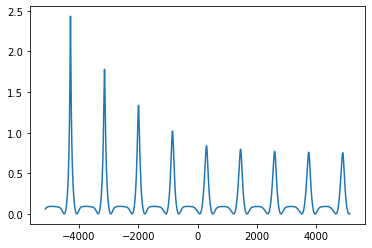

 79%|███████▉  | 79/100 [16:13:46<1:27:49, 250.92s/it]

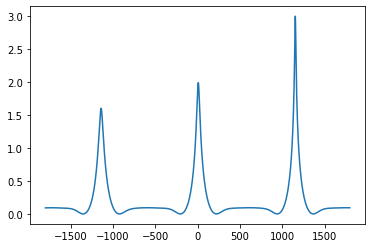

 80%|████████  | 80/100 [16:14:35<1:03:24, 190.22s/it]

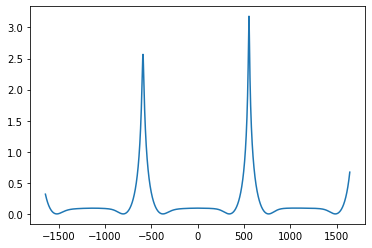

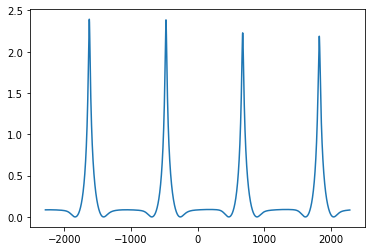

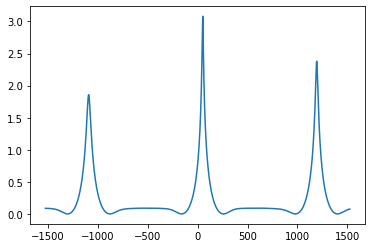

 82%|████████▏ | 82/100 [16:26:19<1:16:52, 256.27s/it]

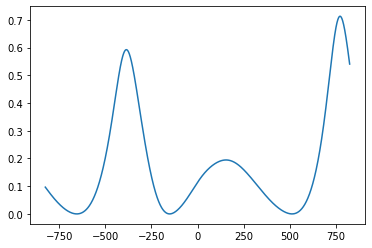

 83%|████████▎ | 83/100 [16:29:26<1:06:41, 235.38s/it]

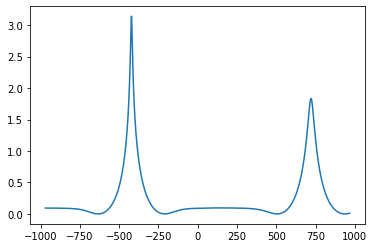

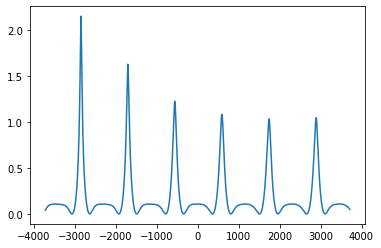

 84%|████████▍ | 84/100 [16:31:19<52:59, 198.73s/it]  

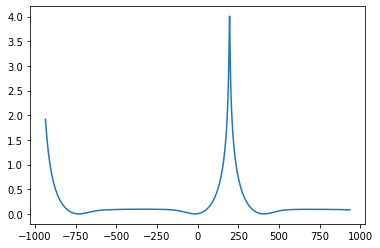

 85%|████████▌ | 85/100 [16:33:07<42:51, 171.42s/it]

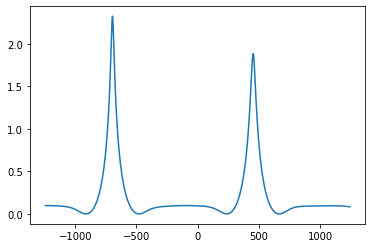

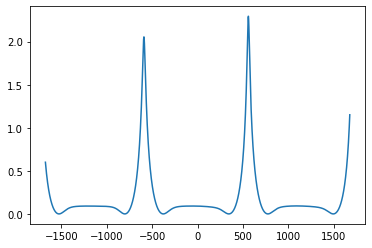

 86%|████████▌ | 86/100 [16:38:26<50:20, 215.76s/it]

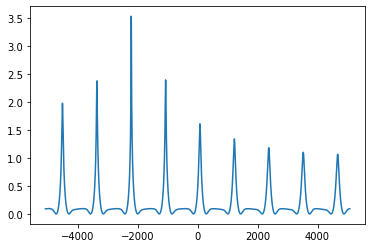

 87%|████████▋ | 87/100 [16:42:06<46:59, 216.89s/it]

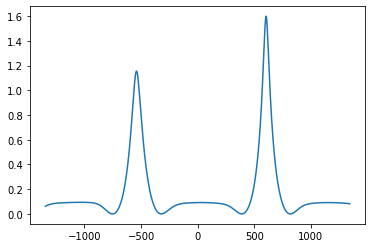

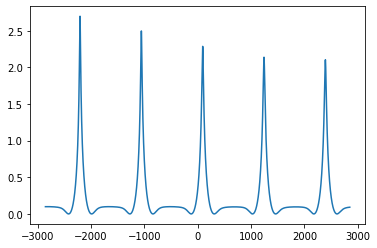

 88%|████████▊ | 88/100 [16:44:01<37:16, 186.35s/it]

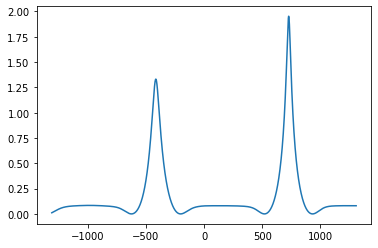

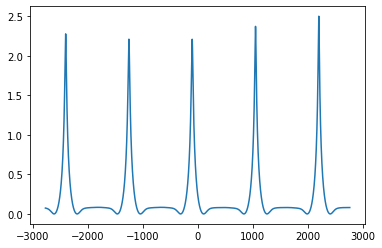

 90%|█████████ | 90/100 [17:11:38<1:32:09, 552.95s/it]

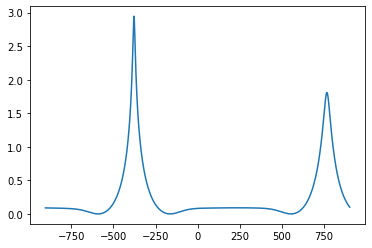

 93%|█████████▎| 93/100 [17:32:47<45:40, 391.49s/it]  

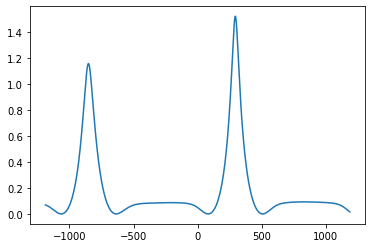

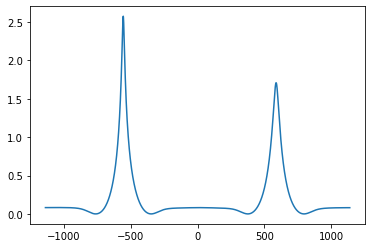

 94%|█████████▍| 94/100 [17:35:57<33:06, 331.04s/it]

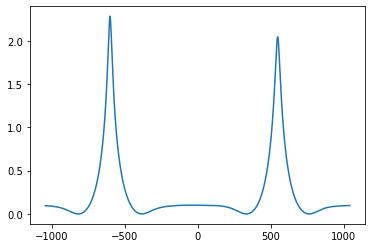

 96%|█████████▌| 96/100 [18:04:30<35:01, 525.50s/it]  

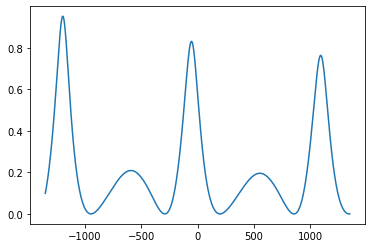

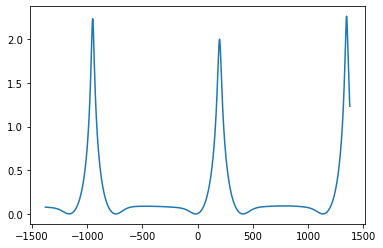

 97%|█████████▋| 97/100 [18:09:47<23:08, 462.91s/it]

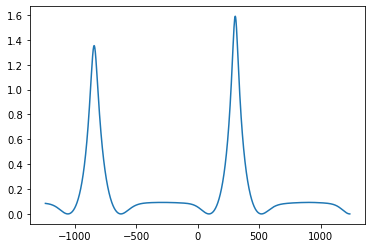

 98%|█████████▊| 98/100 [18:10:37<11:18, 339.08s/it]

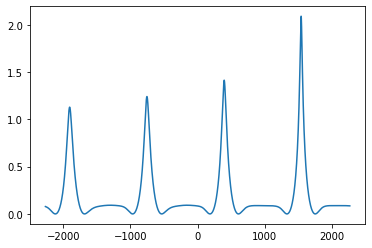

 99%|█████████▉| 99/100 [18:15:55<05:32, 332.58s/it]

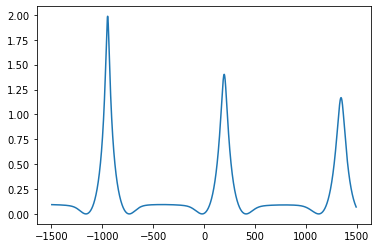

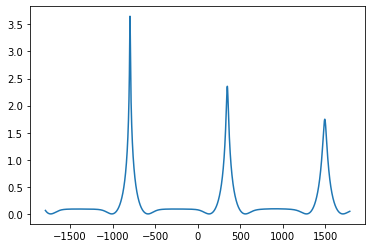

100%|██████████| 100/100 [18:30:39<00:00, 666.39s/it]


In [44]:
iterations = 100
# mr = most_realistic
info = []   # [(mr_index, mr_LSE, best_LSE, output_length), ...]
wsn.verbose = False
for _ in tqdm(range(iterations)):
    wsn.reset_nodes()
    clusters = wsn.find_clusters(redundant_nodes_per_cluster=1)
    all_peaks, pair_to_ind, cluster_MSTs = get_all_fn_peaks_by_cluster(wsn, clusters=clusters, verbose=False)
    # clusters = None
    real_peaks, output = get_peaks_outputs_by_cluster(wsn, all_peaks, pair_to_ind, clusters, cluster_MSTs)
    most_realistic_peaks = wsn.find_most_realistic_peaks(output, real_peaks)
    output.sort()
    mr_index = output.index(most_realistic_peaks)
    mr_lse = most_realistic_peaks[LSE]
    best_lse = output[0]
    output_length = len(output)

    info.append((
        mr_index,
        mr_lse,
        best_lse,
        output_length
    ))



In [ ]:
info.sort(key=lambda x: x[OUTPUT_LENGTH])
info = np.array(info)
mr_indices, mr_lses, best_lses, output_lengths = info.T

# Plot mr_index and output_length versus output_length
plt.scatter(output_length, mr_index)
plt.xlabel("# Combinations of Peaks")
plt.ylabel("Position of correct peaks")
plt.title("Position of the correct peaks\nin the list of peak combinations\nsorted by LSE versus\nthe length of that list")
plt.legend()
plt.show()

# Plot mr_percentile - sorted by output_length
plt.scatter(output_length, mr_index / output_length)
plt.xlabel("# Combinations of peaks")
plt.title("Percentile of the LSE of the\ncorrect peaks in the list of\npeak combinations\nsorted by LSE")
plt.show()

# Plot lses for mr and best
plt.scatter(output_lengths, mr_lses, label="Correct peaks")
plt.scatter(output_lengths, best_lses, label="Lowest LSE")
plt.xlabel("# Combinations of peaks")
plt.ylabel("LSE")
plt.title("LSE for the correct peaks\nand lowest LSE")
plt.show()
